In [ ]:
import numpy as np
from PIL import Image
from scipy import ndimage
import os
import sys
import time
hspath = os.path.abspath('./HWS/')
if hspath not in sys.path:
    sys.path.append(hspath)

from HS_Image import *
from HS_Centroids import *
from HS_Gradients import *
from HS_WFP  import *
import HSM_WFN
import matplotlib.pylab as plt
plt.ion()

import HSM_Zernike
import importlib
importlib.reload(HSM_Zernike)

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)


def calc_centroids(data_dir, image0, ext='.tif', ref='none', radius = 11):
    #Calculate centroids from an image file, if ref is given use this as a template
    file0 = Image.open(data_dir+image0+ext)
    im0 = np.array(file0)[:,:,0]
    hsi_im0 = HS_Image()
    hsi_im0.original_image = im0
    hsi_im0.background = 0
    hsi_im0.process_image()
    hsc_im0 = HS_Centroids()
    hsc_im0.hsimage = hsi_im0
    hsc_im0.radius = radius ###What is this number?
    if ref == 'none':
        hsc_im0.find_centroids()
    else:
        hsc_im0.find_centroids_using_template(ref.centroids)
    return hsc_im0

def calc_origin(data_dir, ref_name, crop = 200, ext = '.tif'):
    sam = np.array(Image.open(data_dir + ref_name + ext))
    sam = sam[crop:2048-crop,crop:2048-crop]
    origin1 = ndimage.measurements.center_of_mass(sam)
    origin = np.array(origin1)[0:2]+crop
    return origin

def calc_grad(ref, live, origin, lever_arm = 4.1e-3, magnif = 1/0.7, pixel_size = 2*5.86e-6):
    #calculate a gradient based on a live image and a reference
    hsg_raw = HS_Gradients(ref, live)
    hsg_raw.lever_arm = lever_arm
    hsg_raw.magnification = magnif
    hsg_raw.pixel_size = pixel_size
    hsg_raw.origin = origin
    hsg_raw.construct_gradients()
    grad_notilt = hsg_raw.gradients[:,:2]-np.mean(hsg_raw.gradients[:,:2],axis=0)
    live = HS_Centroids()
    live.centroids = ref.centroids + grad_notilt*(hsg_raw.lever_arm*hsg_raw.magnification/(hsg_raw.pixel_size))
    hsg = HS_Gradients(ref, live)
    hsg.pixel_size = hsg_raw.pixel_size
    hsg.magnification = hsg_raw.magnification
    hsg.lever_arm = hsg_raw.lever_arm
    hsg.construct_gradients()
    hsg.origin = origin
    hsg.construct_gradients()
    return hsg

def plot_grads(ref, live, origin, lever_arm = 4.1e-3, magnif = 1/0.7, pixel_size = 2*5.86e-6, title = 'Quiver plot'):
    hsg = calc_grad(ref, live, origin, pixel_size = pixel_size, magnif = magnif, lever_arm=lever_arm)
    
    hswfp = HS_WFP(hsg)
    hswfp.compute_poly_coeffs()
    hswfp.compute_seidel_coeffs()
    cents = hsg.gradients[:,2:] #arrow locations
    Sgrads = -hswfp.seidel_coeffs['spherical_power']*cents 
    resgrads = hsg.gradients[:,:2]-Sgrads #subtract defocus from arrow directions

    fig, axs = plt.subplots(1,2,figsize=(16,8))
    plt.suptitle(title)
    axs[0].quiver(hsg.gradients[:,2],hsg.gradients[:,3],hsg.gradients[:,0],hsg.gradients[:,1])
    axs[1].quiver(hsg.gradients[:,2],hsg.gradients[:,3],resgrads[:,0],resgrads[:,1])
    axs[0].set_xlabel('[m]')
    axs[1].set_xlabel('[m]')
    axs[0].set_ylabel('[m]')
    axs[1].set_ylabel('[m]')
    axs[0].set_title('Gradients including defocus')
    axs[1].set_title('Gradients with defocus removed')
        
def calc_defocus_seidel(ref, live, origin, lever_arm = 4.1e-3, magnif = 1/0.7, pixel_size = 2*5.86e-6):
    hsg1 = calc_grad(ref, live, origin,  lever_arm = lever_arm, magnif = magnif, pixel_size = pixel_size)
    hswfp1 = HS_WFP(hsg1)
    hswfp1.compute_poly_coeffs()
    hswfp1.compute_seidel_coeffs()
    defocus1 = -hswfp1.seidel_coeffs['spherical_power']
    return defocus1

def calc_defocus_bcoeff(hsg, bcoeff, ratio):
    W20 = 2*sqrt(3)*(bcoeff[3]) - 6*sqrt(5)*(bcoeff[11])-sqrt(sqrt(6)*bcoeff[2]**2+sqrt(6)*bcoeff[4]**2)
    W22 = 2*sqrt(sqrt(6)*bcoeff[2]**2+sqrt(6)*bcoeff[4]**2)
    W40 = 6*sqrt(5)*(bcoeff[11]) 
    S = 2*W20/(ratio*Rmax)**2
#     #S = 55e-3
#     As =  W22/(ratio*Rmax)**2
#     theta = np.rad2deg((np.arctan(bcoeff[4]/bcoeff[5])+np.pi)%(2*np.pi))
#     Rs = 2/S
    
    return S

def plot_numerical_wavefront(hsg, bcoeff, ratio, title = 'Plot'):
    # Constants for generating wavefront plots
    x = np.linspace(-1,1,300)
    y = np.linspace(-1,1,300)
    X,Y = np.meshgrid(x,y)
    R,PHI = HSM_Zernike.cart2pol(X,Y)

    #wavefrom from zernicke polynomials
    wfZ = HSM_Zernike.construct_wf(R,PHI, bcoeff)
    wfZ[X**2+Y**2>1]=np.nan
    wfZ -= np.nan_to_num(wfZ).max()
    wfZ = np.abs(wfZ) 
    wfZ -= np.nan_to_num(wfZ).mean()

    Rmax = np.min([abs(hsg.gradients[:,2].min()),hsg.gradients[:,2].max(),abs(hsg.gradients[:,3].min()),hsg.gradients[:,3].max()]) # Radius of circular pupil over which Zernikecoeffs are evaulated


    gspacing = Rmax*ratio*(x[1]-x[0])
    cents = hsg.gradients[:,2:]
    limits = {}
    limits['x'] = array([-Rmax*ratio,Rmax*ratio])
    limits['y'] = array([-Rmax*ratio,Rmax*ratio])
    
    # generate numerical wavefront
    wfn = HSM_WFN.calculate_wf(hsg.gradients[:,2:],hsg.gradients[:,:2],limits, gspacing)
    wfn[X**2+Y**2>1]=np.nan #remove background noise
    wfn -= np.min((np.nan_to_num(wfn))[np.nonzero(np.nan_to_num(wfn))])
    wfn = np.abs(wfn)
    wfn -= np.nan_to_num(wfn).mean()
    
#     #update co-ordinate system
#     com_wf = np.rint(ndimage.measurements.center_of_mass(np.nan_to_num(wfn))).astype(int) # centroid given in term of idex
#     # centroi in term of X,Y 
#     xcent = Rmax*ratio*X[com_wf[0],com_wf[1]] # given in term of metric unit
#     ycent = Rmax*ratio*Y[com_wf[0],com_wf[1]]  # given in term of metric unit
#     # Reconstruct the origin in pixel value in hsg_gradients using the new centroids
#     xcent_p = xcent/(hsg.magnification*hsg.pixel_size)
#     ycent_p = ycent/(hsg.magnification*hsg.pixel_size)
#     origin_new = hsg.origin+[xcent_p,ycent_p]
#     print('new origin is %s'%origin_new)
#     # # Reset the origin so we analyse the center of deformation
#     hsg.origin = origin_new
#     hsg.construct_gradients()
#     Rmax = np.min([abs(hsg.gradients[:,2].min()),hsg.gradients[:,2].max(),abs(hsg.gradients[:,3].min()),hsg.gradients[:,3].max()]) # Radius of circular pupil over which Zernikecoeffs are evaulated
#     bcoeff = HSM_Zernike.compute_Zernike_from_hsg(hsg,iorder,R0=ratio*Rmax)

    W20 = 2*sqrt(3)*(bcoeff[3]) - 6*sqrt(5)*(bcoeff[11])-sqrt(sqrt(6)*bcoeff[2]**2+sqrt(6)*bcoeff[4]**2)
    W22 = 2*sqrt(sqrt(6)*bcoeff[2]**2+sqrt(6)*bcoeff[4]**2)
    W40 = 6*sqrt(5)*(bcoeff[11]) 
    S = 2*W20/(ratio*Rmax)**2
    #S = 55e-3
    As =  W22/(ratio*Rmax)**2
    theta = np.rad2deg((np.arctan(bcoeff[4]/bcoeff[5])+np.pi)%(2*np.pi))
    Rs = 2/S

    hsg_noS = HSM_Zernike.construct_residual_gradient(hsg, Rs)
    bcoeff_noS = HSM_Zernike.compute_Zernike_from_hsg(hsg_noS,iorder,R0=ratio*Rmax)

    hswfp = HS_WFP(hsg)
    hswfp.compute_poly_coeffs()
    hswfp.compute_seidel_coeffs()
    poly_coeffs = zeros(shape(hswfp.poly_coeffs_array))
    poly_coeffs[0:5] = hswfp.poly_coeffs_array[0:5] # remove all quadratic component

    print('Defocus: ',1e3*S,' mD')
    print('Astigmatism:', 1e3*As,' mD')
    print('Astigmatism angle:', theta)
    
    # generate numerical wavefront
    wfn = HSM_WFN.calculate_wf(hsg.gradients[:,2:],hsg.gradients[:,:2],limits, gspacing)
    wfn[X**2+Y**2>1]=np.nan #remove background noise
    wfn -= np.min((np.nan_to_num(wfn))[np.nonzero(np.nan_to_num(wfn))])
    wfn = np.abs(wfn)
    wfn -= np.nan_to_num(wfn).mean()

    wfn_noS = HSM_WFN.calculate_wf(hsg.gradients[:,2:],hsg_noS.gradients[:,:2],limits, gspacing) ####WHY DOESN'T THE NO_S AXES WORK?
    wfn_noS[X**2+Y**2>1]=np.nan
    wfn_noS -= np.min((np.nan_to_num(wfn_noS))[np.nonzero(np.nan_to_num(wfn_noS))])
    wfn_noS -= np.nan_to_num(wfn_noS).mean()

#     gradients_quad = hswfp.calculate_gradients(poly_coeffs)
#     gradients_noquad = hsg.gradients[:,0:2] - gradients_quad
#     wfn_noquad = HSM_WFN.calculate_wf(hsg.gradients[:,2:],gradients_noquad,limits, gspacing)
#     wfn_noquad[X**2+Y**2>1]=np.nan
#     wfn_noquad -= np.min((np.nan_to_num(wfn_noquad))[np.nonzero(np.nan_to_num(wfn_noquad))])
#     wfn_noquad -= np.nan_to_num(wfn_noquad).mean()

    bcoeffnm = 1e9*bcoeff_noS[:14]

    #generate plots
    fig, axs = plt.subplots(3,1,figsize=(12,24))
    plt.suptitle(title)
    
    pl1 = axs[0].contourf(1e3*Rmax*ratio*X,1e3*Rmax*ratio*Y, 1e6*wfn,25, cmap='jet')
    cb1=plt.colorbar(pl1,ax=axs[0])
    
    pl2=axs[1].contourf(1e3*Rmax*ratio*X,1e3*Rmax*ratio*Y, 1e6*wfn_noS, 25, cmap='jet')
    cb2=plt.colorbar(pl2,ax=axs[1])
    
    pl3 = axs[2].bar(np.arange(len(bcoeffnm))+1, bcoeffnm, width =.5)
    xticks = np.arange(1,15)
    axs[2].set_xticks(xticks)
    axs[2].set_xticklabels(['1,-1', '1,1', '2,-2', '2,0', '2,2', '3,-3', '3,-1', '3,1', '3,3', '4,-4','4,-2', '4,0', '4,2', '4,4'])
    axs[2].set_xlabel('Zernike mode (n,m)')
    axs[2].set_ylabel('Zernike coefficient amplitude (nm)')
    axs[2].set_ylim([-200, 200])
    #ax[2].grid(True,which='minor',linestyle='-')
    axs[2].grid(True,which='major',linestyle='--')
    
    
    cb1.set_label(r'$\mu$m')
    cb2.set_label(r'$\mu$m')

    axs[0].set_aspect('equal')
    axs[0].set_xlabel('x (mm)')
    axs[0].set_ylabel('y (mm)')
    
    axs[1].set_aspect('equal')    
    axs[1].set_ylabel('y (mm)')
    axs[1].set_xlabel('x (mm)')

    axs[0].set_title('Numerical WF')
    axs[1].set_title('Defocus removed')

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    
def plot_mode_decomp(hsg, bcoeff, ratio, title = 'Plot'):
    Rmax = np.min([abs(hsg.gradients[:,2].min()),hsg.gradients[:,2].max(),abs(hsg.gradients[:,3].min()),hsg.gradients[:,3].max()]) # Radius of circular pupil over which Zernikecoeffs are evaulated
    W20 = 2*sqrt(3)*(bcoeff[3]) - 6*sqrt(5)*(bcoeff[11])-sqrt(sqrt(6)*bcoeff[2]**2+sqrt(6)*bcoeff[4]**2)
    W22 = 2*sqrt(sqrt(6)*bcoeff[2]**2+sqrt(6)*bcoeff[4]**2)
    W40 = 6*sqrt(5)*(bcoeff[11]) 
    S = 2*W20/(ratio*Rmax)**2
    #S = 55e-3
    As =  W22/(ratio*Rmax)**2
    theta = np.rad2deg((np.arctan(bcoeff[4]/bcoeff[5])+np.pi)%(2*np.pi))
    Rs = 2/S

    hsg_noS = HSM_Zernike.construct_residual_gradient(hsg, Rs)
    bcoeff_noS = HSM_Zernike.compute_Zernike_from_hsg(hsg_noS,iorder,R0=ratio*Rmax)
 
    HSM_Zernike.bar_plot_zernike(bcoeff_noS, i=None, logplot = False)
    bcoeffnm = 1e9*bcoeff[:14]
    
    fig=plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.bar(np.arange(len(bcoeffnm))+1, bcoeffnm, width =.5)
    xticks = np.arange(1,15)
    plt.xticks(xticks, ['1,-1', '1,1', '2,-2', '2,0', '2,2', '3,-3', '3,-1', '3,1', '3,3', '4,-4','4,-2', '4,0', '4,2', '4,4'])
    plt.xlabel('Zernike mode (n,m)')
    ax.set_ylabel('Zernike coefficient amplitude (nm)')
    ax.set_ylim([-40, 40])
    ax.grid(True,which='minor',linestyle='-')
    ax.grid(True,which='major',linestyle='--')
    plt.title(title)
    plt.show() 
    
    #HSM_Zernike.bar_plot_zernike(bcoeff_noS, i=None, logplot = False, title = title)
 

In [ ]:
data_dir = './data/20200225/'


In [35]:
#read in data, calculate refence centroids, calculate image centroids, plot gradients (if wanted)
data_dir = './data/20200225/'

origin0 = np.array([1040, 985])
voltage_min = 0
voltage_max = 151
voltage_step = 10
pzv = np.arange(voltage_min,voltage_max,voltage_step)
pzv=np.append(pzv,150)

pzv_d = np.array([150, 140, 130, 120, 110, 100, 90, 80, 70, 60, 40, 30, 20, 10, 0])

iorder =  50
ratio = 0.5 #cropping away some trash

plot_quivers = False
plot_mode_decomposition = False
plot_wavefronts = False
defocus0 = np.empty((0,len(pzv))) #to store the defocus

ii = 0
S_ = []
A_ = []
theta_ = []
HOMS_ = []

x = np.linspace(-1,1,300)
y = np.linspace(-1,1,300)
X,Y = np.meshgrid(x,y)


for v in pzv:
    if 0<=v<40:
        ref0 = calc_centroids(data_dir,'V0_120')
    if 40<=v<80:
        ref0 = calc_centroids(data_dir,'V0_120')
    if 80<=v<120:
        ref0 = calc_centroids(data_dir,'V0_120')
    if 120<=v<160:
        ref0 = calc_centroids(data_dir,'V0_120')
    im0 = calc_centroids(data_dir,'V%s'%v, ref=ref0)
    hsg = calc_grad(ref0, im0, origin0)
    Rmax = np.min([abs(hsg.gradients[:,2].min()),hsg.gradients[:,2].max(),abs(hsg.gradients[:,3].min()),hsg.gradients[:,3].max()]) # Radius of circular pupil over which Zernikecoeffs are evaulated
    bcoeff = HSM_Zernike.compute_Zernike_from_hsg(hsg,iorder,R0=ratio*Rmax)
    defocus0 = np.append(defocus0, calc_defocus_bcoeff(hsg, bcoeff, ratio))
    
    gspacing = Rmax*ratio*(x[1]-x[0])
    cents = hsg.gradients[:,2:]
    limits = {}
    limits['x'] = array([-Rmax*ratio,Rmax*ratio])
    limits['y'] = array([-Rmax*ratio,Rmax*ratio])
    
    if plot_quivers == True:
        plot_grads(ref0,im0,origin0,pixel_size = 2*5.86e-6, title = 'V = %s V'%v)
        #plt.savefig('./figures/20200226/quivers%s.pdf'%v,dpi=300)
    if plot_mode_decomposition == True:
        plot_mode_decomp(hsg, bcoeff, ratio, title = 'Mode decomposition V = %s V'%v)
        #plt.savefig('./figures/modedecomp_%s.pdf'%v,dpi=300)
    if plot_wavefronts == True:
        plot_numerical_wavefront(hsg,bcoeff,ratio, title = 'V = %s V'%v)
        #plt.savefig('./figures/20200226/wavefront_%s.pdf'%v,dpi=300)
       
    
for v in pzv_d:
    if 0<=v<40:
        ref0 = calc_centroids(data_dir,'V0_0_d')
    if 40<=v<80:
        ref0 = calc_centroids(data_dir,'V0_40_d')
    if 80<=v<120:
        ref0 = calc_centroids(data_dir,'V0_120_d')
    if 120<=v<160:
        ref0 = calc_centroids(data_dir,'V0_120_d')
    im0 = calc_centroids(data_dir,'V%s_d'%v, ref=ref0)
    hsg = calc_grad(ref0, im0, origin0)
    Rmax = np.min([abs(hsg.gradients[:,2].min()),hsg.gradients[:,2].max(),abs(hsg.gradients[:,3].min()),hsg.gradients[:,3].max()]) # Radius of circular pupil over which Zernikecoeffs are evaulated
    bcoeff = HSM_Zernike.compute_Zernike_from_hsg(hsg,iorder,R0=ratio*Rmax)
    defocus0 = np.append(defocus0, calc_defocus_bcoeff(hsg, bcoeff, ratio))
    
    gspacing = Rmax*ratio*(x[1]-x[0])
    cents = hsg.gradients[:,2:]
    limits = {}
    limits['x'] = array([-Rmax*ratio,Rmax*ratio])
    limits['y'] = array([-Rmax*ratio,Rmax*ratio])
    
    if plot_quivers == True:
        plot_grads(ref0,im0,origin0,pixel_size = 2*5.86e-6, title = 'V = %s V'%v)
        #plt.savefig('./figures/20200226/quivers%s.pdf'%v,dpi=300)
    if plot_mode_decomposition == True:
        plot_mode_decomp(hsg, bcoeff, ratio, title = 'Mode decomposition V = %s V'%v)
        #plt.savefig('./figures/modedecomp_%s.pdf'%v,dpi=300)
    if plot_wavefronts == True:
        plot_numerical_wavefront(hsg,bcoeff,ratio, title = 'V = %s V'%v)
        #plt.savefig('./figures/20200226/wavefront_%s.pdf'%v,dpi=300)
        


In [ ]:
S_grads

In [24]:
from pykat import BeamParam
from pykat.optics.gaussian_beams import HG_mode
from pykat.optics.knm import riemann_HG_knm, makeCouplingMatrix, plot_knm_matrix
from pykat.optics.maps import curvedmap
from collections import defaultdict

x = np.linspace(-1,1,300)
y = np.linspace(-1,1,300)
X,Y = np.meshgrid(x,y)

R,PHI = HSM_Zernike.cart2pol(X,Y)
HOMS_ = []

ratio = 0.5


def gauss_amp(A, wx, wy, Rcx, Rcy, dx,dy, x):
    qx = BeamParam(rc=Rcx, w=wx)
    qy = BeamParam(rc=Rcy, w=wy)
    hg = HG_mode(qx, qy)
    #E  = A*rebin(hg.Unm(x-dx*px,x-dy*px), (512,512))
    E  = A*hg.Unm(x-dx*px,x-dy*px)
    return E

#im = calc_centroids(data_dir,'V%s' %v,ref=ref0)
im0 = calc_centroids(data_dir,'V0', ref=ref0, radius = 10)
hsg = calc_grad(ref0, im0, origin0)
Rmax = np.min([abs(hsg.gradients[:,2].min()),hsg.gradients[:,2].max(),abs(hsg.gradients[:,3].min()),hsg.gradients[:,3].max()]) # Radius of circular pupil over which Zernikecoeffs are evaulated
gspacing = Rmax*ratio*(x[1]-x[0]) #don't do this

voltage_min = 0
voltage_max = 151
voltage_step = 30
pzv = np.arange(voltage_min,voltage_max,voltage_step)


for v in pzv:
    HOMS = []
    if 0<=v<40:
        ref0 = calc_centroids(data_dir,'V0_40')
    if 40<=v<80:
        ref0 = calc_centroids(data_dir,'V0_40')
    if 80<=v<120:
        ref0 = calc_centroids(data_dir,'V0_80')
    if 120<=v<160:
        ref0 = calc_centroids(data_dir,'V0_120')
    im0 = calc_centroids(data_dir,'V%s'%v, ref=ref0)
    hsg = calc_grad(ref0, im0, origin0)
    #Rmax = np.min([abs(hsg.gradients[:,2].min()),hsg.gradients[:,2].max(),abs(hsg.gradients[:,3].min()),hsg.gradients[:,3].max()]) # Radius of circular pupil over which Zernikecoeffs are evaulated
    #print(Rmax)
    bcoeff = HSM_Zernike.compute_Zernike_from_hsg(hsg,iorder,R0=ratio*Rmax)
    
    print('calculated b coeffs!')
    
    #gspacing = Rmax*ratio*(x[1]-x[0]) #don't do this
    #print(gspacing)
    cents = hsg.gradients[:,2:]
    limits = {}
    limits['x'] = array([-Rmax*ratio,Rmax*ratio])
    limits['y'] = array([-Rmax*ratio,Rmax*ratio])
    
    print('calculated limits!')

    W20 = 2*sqrt(3)*(bcoeff[3]) - 6*sqrt(5)*(bcoeff[11])-sqrt(sqrt(6)*bcoeff[2]**2+sqrt(6)*bcoeff[4]**2)
    W22 = 2*sqrt(sqrt(6)*bcoeff[2]**2+sqrt(6)*bcoeff[4]**2)
    S = 2*W20/(ratio*Rmax)**2
    As =  W22/(ratio*Rmax)**2
    theta = np.rad2deg((np.arctan(bcoeff[4]/bcoeff[5])+np.pi)%(2*np.pi))
    Rs = 2/S
    
    print(S)

    hsg_noS = HSM_Zernike.construct_residual_gradient(hsg, Rs)
    bcoeff_noS = HSM_Zernike.compute_Zernike_from_hsg(hsg_noS,iorder,R0=ratio*Rmax)

    print('constructed residual gradients')
    
#     # generate numerical wavefront
#     wfn = HSM_WFN.calculate_wf(hsg.gradients[:,2:],hsg.gradients[:,:2],limits, gspacing)
#     wfn[X**2+Y**2>1]=np.nan #remove background noise
#     wfn -= np.min((np.nan_to_num(wfn))[np.nonzero(np.nan_to_num(wfn))])
#     wfn = np.abs(wfn)
#     wfn -= np.nan_to_num(wfn).mean()
    
    wfn_noS = HSM_WFN.calculate_wf(hsg.gradients[:,2:],hsg_noS.gradients[:,:2],limits, gspacing) ####WHY DOESN'T THE NO_S AXES WORK?
    wfn_noS[X**2+Y**2>1]=np.nan
    wfn_noS -= np.min((np.nan_to_num(wfn_noS))[np.nonzero(np.nan_to_num(wfn_noS))])
    wfn_noS -= np.nan_to_num(wfn_noS).mean()

    print('generated numerical wavefront!')
    
    px = gspacing
    N = np.shape(wfn_noS)[0]
    x1 = np.arange(-N/2, N/2)*px
    
    lambd = 1064e-9
    k = 2*np.pi/lambd
    w = 1e-3*np.arange(0.2,2,0.1)

    print('set up w vector')
    
    for iw in w:
        E0 = gauss_amp(1,iw,iw, 1e99, 1e99, 0, 0, x1)
        E0[X**2+Y**2>1]=np.nan
        Erefl = np.nan_to_num(E0)*np.exp(1j*k*np.nan_to_num(wfn_noS))
        I0 = np.sum(np.nan_to_num(E0)*np.conjugate(Erefl)*px**2)
        I1 = np.sum(np.conjugate(np.nan_to_num(E0))*(Erefl)*px**2)
        I2 = np.sum(np.nan_to_num(E0)*np.conjugate(np.nan_to_num(E0))*px**2)
        HOMS.append((1-((I0*I1)/I2))*100 )# express in percentage
        #print(w)
    
    HOMS = np.transpose(HOMS)
    HOMS_.append(HOMS)
    print('done a loop!')

calculated b coeffs!
calculated limits!
0.0031099981360291724
constructed residual gradients
generated numerical wavefront!
set up w vector
done a loop!
calculated b coeffs!
calculated limits!
0.014126517643592807
constructed residual gradients
generated numerical wavefront!
set up w vector
done a loop!
calculated b coeffs!
calculated limits!
0.02791386504383944
constructed residual gradients
generated numerical wavefront!
set up w vector
done a loop!
calculated b coeffs!
calculated limits!
0.04359632975183171
constructed residual gradients
generated numerical wavefront!
set up w vector
done a loop!
calculated b coeffs!
calculated limits!
0.057899234798200784
constructed residual gradients
generated numerical wavefront!
set up w vector
done a loop!
calculated b coeffs!
calculated limits!
0.0742998376770603
constructed residual gradients
generated numerical wavefront!
set up w vector
done a loop!


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

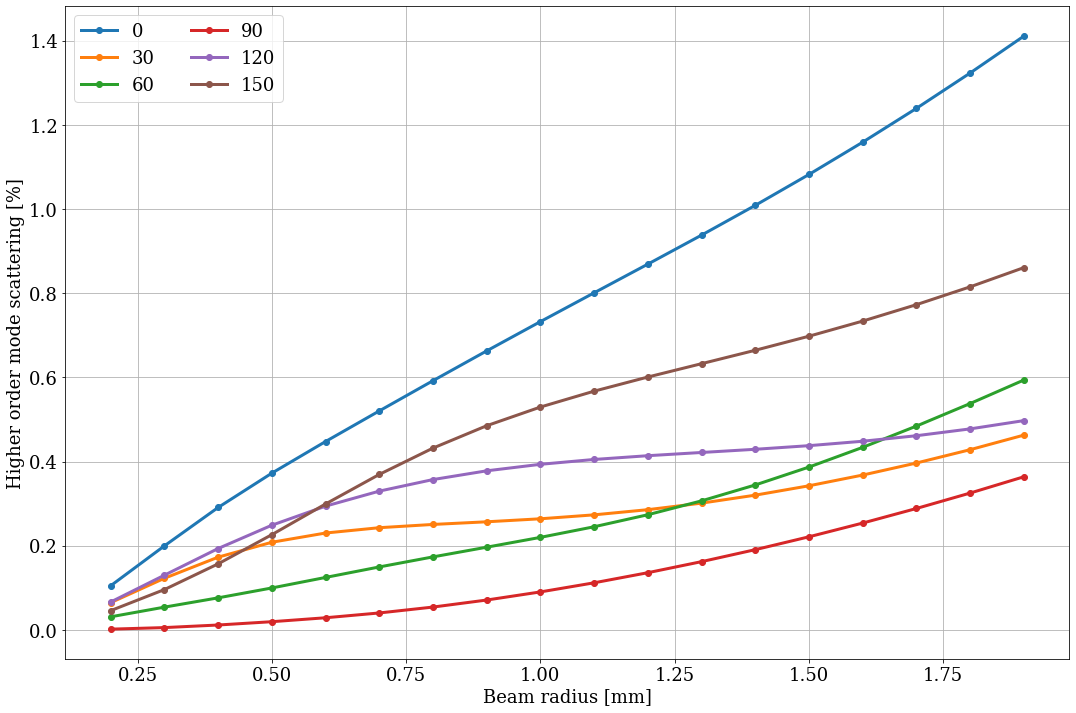

In [25]:
plt.figure(figsize =(18,12))

for ii,_ in enumerate(pzv):
    plt.plot(1e3*w, np.real(np.transpose(HOMS_[ii])), 'o-',linewidth=3, label=_)
plt.legend(ncol=2)
plt.grid(which='both')
plt.xlabel('Beam radius [mm]')
plt.ylabel('Higher order mode scattering [%]')
plt.tight_layout
#plt.savefig('./figures/20200219/HOM.pdf')

Text(0, 0.5, 'Defocus [mD]')

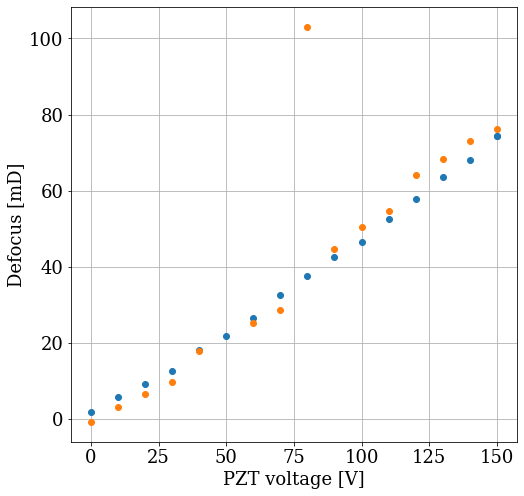

In [36]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

#plot Voltage and Defocus
plt.figure(figsize=(8,8))
plt.plot(pzv, defocus0[0:17]*1e3,'o')
plt.plot(pzv_d, defocus0[17:]*1e3,'o')

plt.grid(which='both')
plt.xlabel('PZT voltage [V]')
plt.ylabel('Defocus [mD]')
#plt.savefig('./figures/20200219/defocus.pdf')



In [ ]:
# modal decomposition
hsg = calc_grad(ref0, im0, origin0, pixel_size = 2*5.86e-6)

iorder =  50
ratio = 0.8 #cropping away some trash
Rmax = np.min([abs(hsg.gradients[:,2].min()),hsg.gradients[:,2].max(),abs(hsg.gradients[:,3].min()),hsg.gradients[:,3].max()]) # Radius of circular pupil over which Zernikecoeffs are evaulated
bcoeff = HSM_Zernike.compute_Zernike_from_hsg(hsg,iorder,R0=ratio*Rmax)
a = HSM_Zernike.bar_plot_zernike(bcoeff, i=None, logplot = False)


In [ ]:
''' ok time for the final boss: hom decomposition as a fn of beam radius'''

In [ ]:
hswfp = HS_WFP(hsg)
hswfp.compute_poly_coeffs()
hswfp.compute_seidel_coeffs()

cents = hsg.gradients[:,2:] #arrow locations
Sgrads = 53e-3*cents 
resgrads = hsg.gradients[:,:2]-Sgrads #subtract defocus from arrow directions

wfn_noS2 = HSM_WFN.calculate_wf(hsg.gradients[:,2:],resgrads,limits, gspacing)
wfn_noS2[X**2+Y**2>1]=np.nan #remove background noise
wfn_noS2 -= np.min((np.nan_to_num(wfn))[np.nonzero(np.nan_to_num(wfn))])
wfn_noS2 = np.abs(wfn)
wfn_noS2 -= np.nan_to_num(wfn).mean()

plt.contourf(1e3*Rmax*ratio*X,1e3*Rmax*ratio*Y, 1e6*wfn_noS2,25, cmap='jet')
plt.colorbar()

In [ ]:
defocus0

Defocus:  74.29983767706031  mD
Astigmatism: 1.8425404368181428  mD
Astigmatism angle: 130.75677429168707


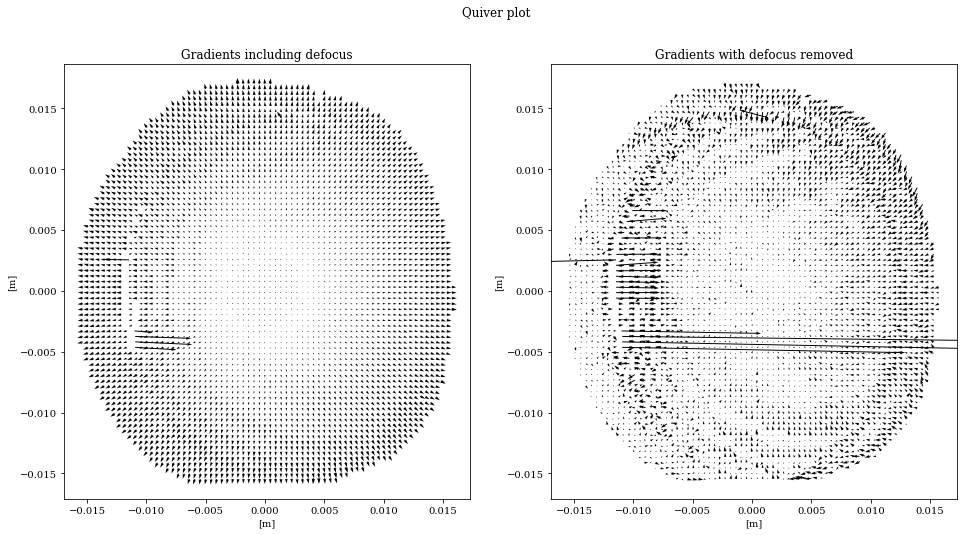

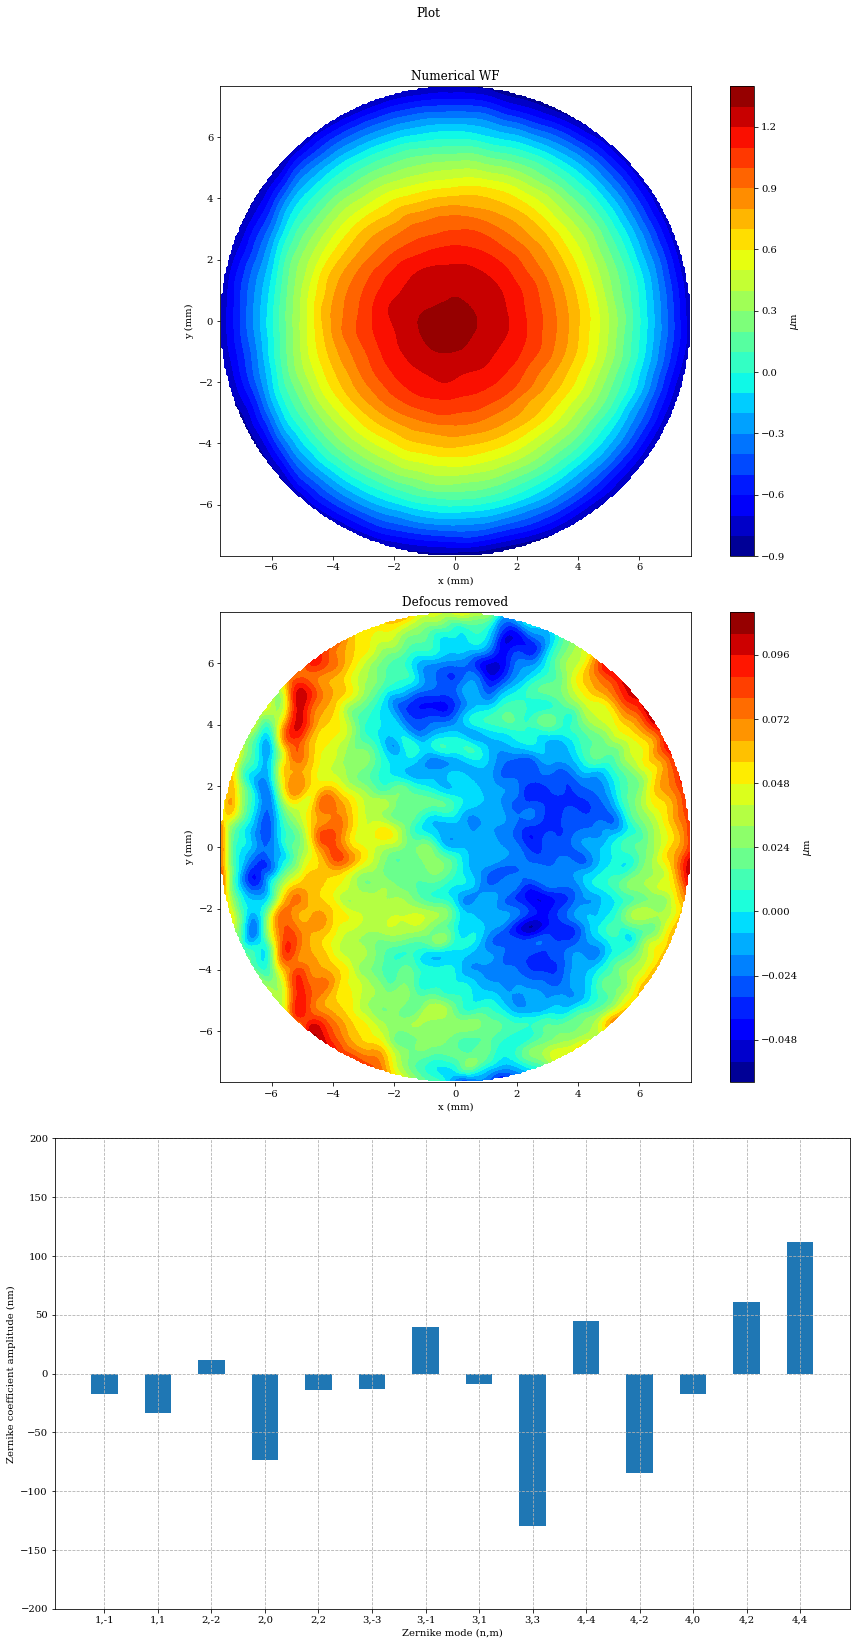

In [13]:
#temporary step: calculate defocus for diff alignments
ref1 = calc_centroids(data_dir,'V0_120')

origin1 = np.array([1040, 985])
im1 = calc_centroids(data_dir,'V150',ref=ref1)

iorder1 = 50

plot_grads(ref1,im1,origin1,pixel_size = 2*5.86e-6)
# defocus1 = calc_defocus(ref1,im1,origin1,pixel_size = 2*5.86e-6)


hsg1 = calc_grad(ref1, im1, origin1)

iorder= 50
ratio1=0.5
Rmax1=np.min([abs(hsg1.gradients[:,2].min()),hsg1.gradients[:,2].max(),abs(hsg1.gradients[:,3].min()),hsg1.gradients[:,3].max()])

bcoeff1 = HSM_Zernike.compute_Zernike_from_hsg(hsg1,iorder1,R0=ratio1*Rmax1)

plot_numerical_wavefront(hsg1,bcoeff1, ratio1)